## https://github.com/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismSmall.ipynb

In [1]:
# %#pip install statsforecast hierarchicalforecast utilsforcast

In [2]:
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
import pandas as pd

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import TopDown
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.preprocessing import fill_gaps
import numpy as np

from ipydatagrid import DataGrid
import pickle
from datetime import date

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\utils.py:236: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [3]:
TEST_PERIODS = 4

In [4]:
spec = [
    ["entity_type"],
    ["entity_type", "top_level_SIC_code"],
    ["entity_type", "top_level_SIC_code", "second_level_SIC_code"],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
        "ticker",
    ],
]

In [53]:
Y_df_load = (
    pd.read_parquet("revenue_data.parquet").rename({"value": "y"}, axis=1).reset_index()
)

## Prep Data

In [54]:
# last date
last_date = pd.to_datetime(date(2023, 9, 30))

In [55]:
# XBRL data starts ~2010
first_date = pd.to_datetime(date(2010, 1, 1))

In [56]:
# remove periods after the date from which we are predicting
Y_df_load = Y_df_load[Y_df_load["ds"] <= last_date]
Y_df_load = Y_df_load[Y_df_load["ds"] >= first_date]

In [57]:
# remove companies for which we do not have current data
Y_df_load = Y_df_load.groupby("ticker").filter(lambda x: x["ds"].max() == last_date)

In [59]:
# Get rid of companies for which we do not have enough data
Y_df_load = Y_df_load.groupby("ticker").filter(lambda x: x.shape[0] > TEST_PERIODS)

In [60]:
pivot_columns = [
    "ticker",
    "top_level_SIC_code",
    "second_level_SIC_code",
    "third_level_SIC_code",
    "fourth_level_SIC_code",
]

In [61]:
# forward fill missing data
Y_df_load = (
    Y_df_load.pivot(
        index="ds",
        columns=pivot_columns,
        values="y",
    )
    .ffill()
    .melt(ignore_index=False, value_name="y")
    .reset_index()
)

In [62]:
Y_df_load = Y_df_load[~Y_df_load["y"].isna()]

In [63]:
Y_df_load["entity_type"] = "company"

## Build training data

In [64]:
Y_df, S_df, tags = aggregate(df=Y_df_load, spec=spec)

In [65]:
Y_df = Y_df.reset_index()

In [66]:
Y_test_df = Y_df.groupby("unique_id").tail(TEST_PERIODS)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df = Y_test_df.set_index("unique_id")

## Base Forecasts

In [67]:
fcst = StatsForecast(models=[AutoARIMA(trace=True), Naive()], freq="QE", n_jobs=-1)

In [36]:
Y_hat_df = fcst.forecast(df=Y_train_df, h=TEST_PERIODS, fitted=True)

KeyboardInterrupt: 

In [68]:
forecast_df = fcst.forecast(
    df=Y_train_df[Y_train_df["unique_id"] == "company"], h=4, fitted=True
)


ARIMA(2,2,2)                   :inf

ARIMA(0,2,0)                   :2597.532641638957

ARIMA(1,2,0)                   :2528.114414296183

ARIMA(0,2,1)                   :2545.5174743548273

ARIMA(2,2,0)                   :2529.4495879897904

ARIMA(1,2,1)                   :2509.4230973025346

ARIMA(2,2,1)                   :2511.974006408399

ARIMA(1,2,2)                   :inf

ARIMA(0,2,2)                   :2523.0330749651225

ARIMA(0,2,2)                   :2523.0330749651225
Now re-fitting the best model(s) without approximations...


ARIMA(1,2,1)                   :2509.4230973025346


C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [69]:
forecast_df

,ds,AutoARIMA,Naive
unique_id,,,
company,2022-12-31,1.346074e+12,1.340075e+12
company,2023-03-31,1.391955e+12,1.340075e+12
company,2023-06-30,1.412095e+12,1.340075e+12
company,2023-09-30,1.448849e+12,1.340075e+12


In [46]:
DataGrid(Y_train_df)

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:1275: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


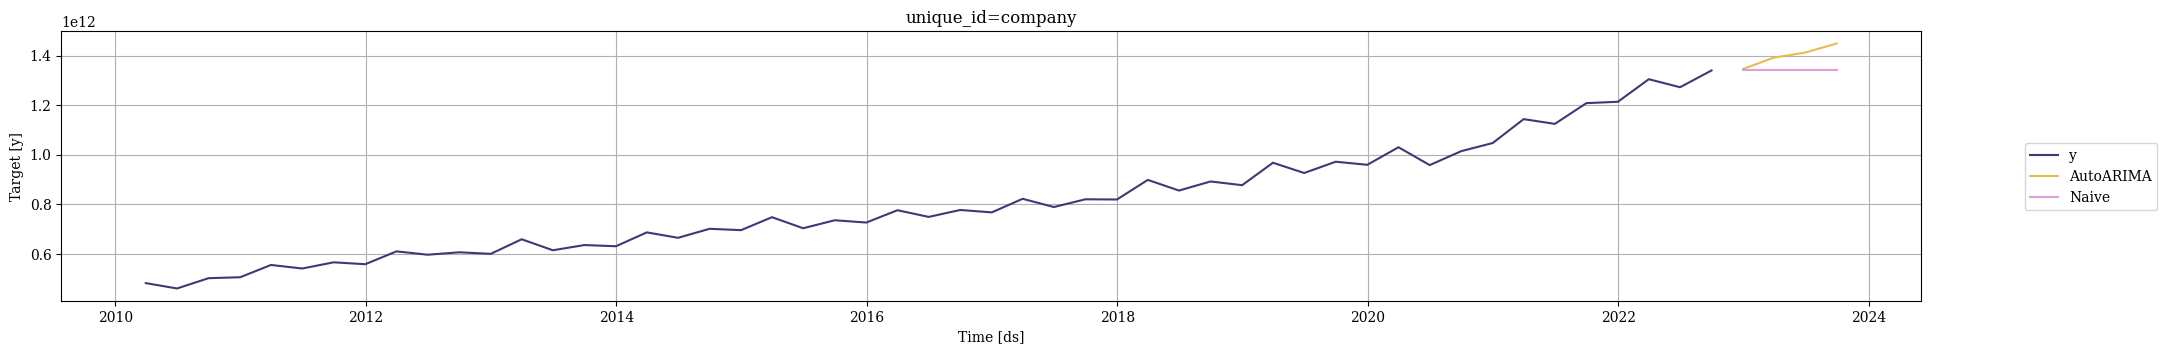

In [70]:
fcst.plot(Y_train_df[Y_train_df["unique_id"] == "company"], forecast_df)

## Hierarchical reconciliation

In [19]:
hrec = HierarchicalReconciliation([TopDown(method="forecast_proportions")])

In [20]:
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df, S=S_df, tags=tags)

In [21]:
plot_df = pd.concat(
    [
        Y_df.reset_index().set_index(["unique_id", "ds"]),
        Y_rec_df.set_index("ds", append=True),
    ],
    axis=1,
)
plot_df = plot_df.reset_index("ds")

In [22]:
hplot = HierarchicalPlot(S=S_df, tags=tags)

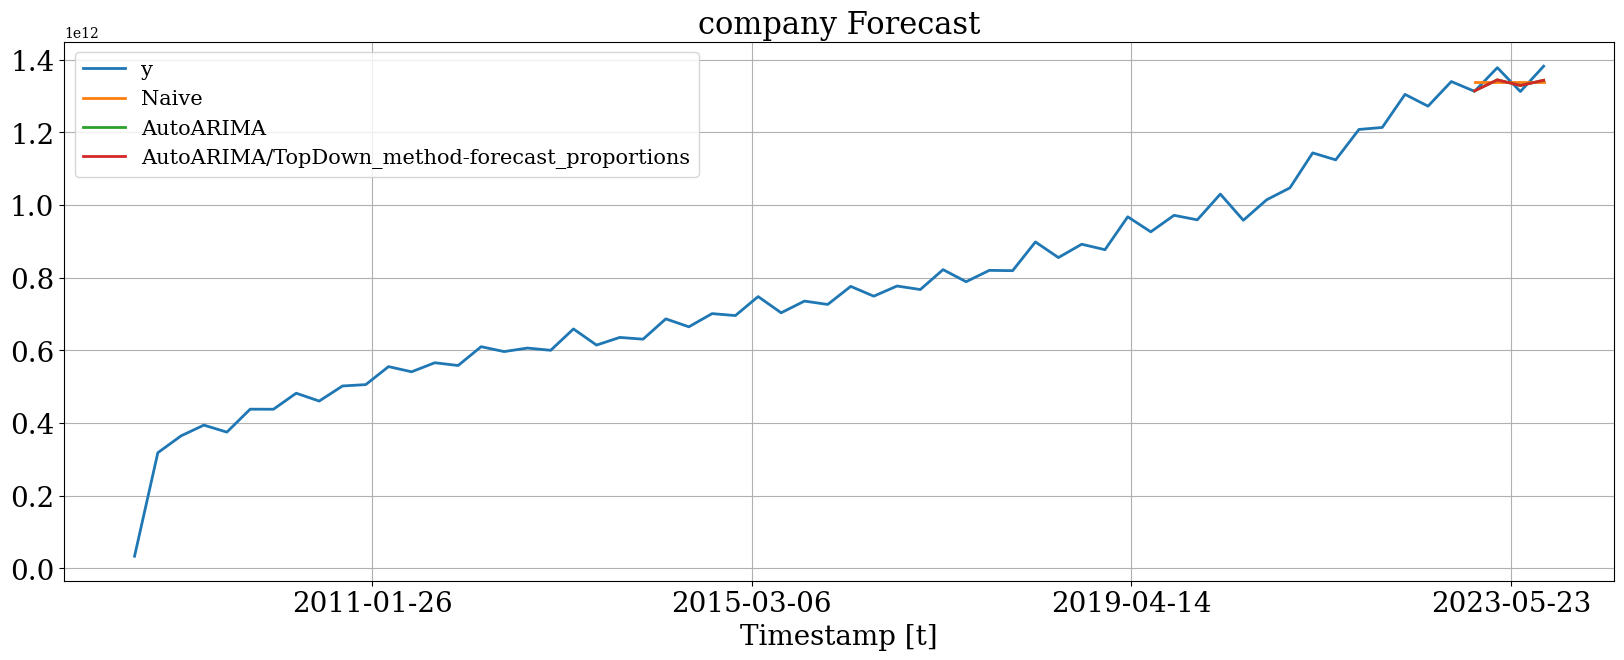

In [23]:
hplot.plot_series(
    series="company",
    Y_df=plot_df,
    models=["y", "Naive", "AutoARIMA", "AutoARIMA/TopDown_method-forecast_proportions"],
    level=[80],
)

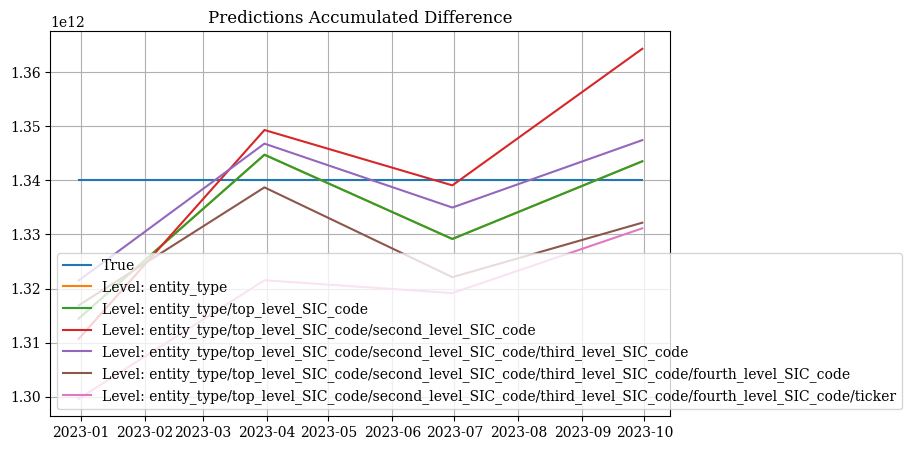

In [24]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_hierarchical_predictions_gap(Y_hat_df.rename({"Naive": "y"}, axis=1))

# Evaluation
## https://github.com/Nixtla/hierarchicalforecast/blob/2296c259542dbd906cfba4b8345c3b72148dad79/nbs/examples/TourismSmall.ipynb#L463

In [25]:
def mse(y, y_hat):
    print(y[:2], y_hat[:2])
    return np.mean((y - y_hat) ** 2)


evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluation = evaluator.evaluate(
    Y_hat_df=Y_rec_df,
    Y_test_df=Y_test_df,
    tags=tags,
    benchmark="Naive",
)

[[1.31316620e+12 1.37826040e+12 1.31257774e+12 1.38223145e+12]
 [1.31316620e+12 1.37826040e+12 1.31257774e+12 1.38223145e+12]] [[1.3144580e+12 1.3447393e+12 1.3291726e+12 1.3435243e+12]
 [1.3144580e+12 1.3447393e+12 1.3291726e+12 1.3435243e+12]]
[[1.31316620e+12 1.37826040e+12 1.31257774e+12 1.38223145e+12]
 [1.31316620e+12 1.37826040e+12 1.31257774e+12 1.38223145e+12]] [[1.3400751e+12 1.3400751e+12 1.3400751e+12 1.3400751e+12]
 [1.3400751e+12 1.3400751e+12 1.3400751e+12 1.3400751e+12]]
[[1.31316620e+12 1.37826040e+12 1.31257774e+12 1.38223145e+12]
 [1.31316620e+12 1.37826040e+12 1.31257774e+12 1.38223145e+12]] [[1.3400751e+12 1.3400751e+12 1.3400751e+12 1.3400751e+12]
 [1.3400751e+12 1.3400751e+12 1.3400751e+12 1.3400751e+12]]
[[1.31316620e+12 1.37826040e+12 1.31257774e+12 1.38223145e+12]
 [1.31316620e+12 1.37826040e+12 1.31257774e+12 1.38223145e+12]] [[1.3400751e+12 1.3400751e+12 1.3400751e+12 1.3400751e+12]
 [1.3400751e+12 1.3400751e+12 1.3400751e+12 1.3400751e+12]]
[[1.31316620e+12